In [1]:
# from asyncio.windows_events import NULL
import numpy as np
from collections import Counter
from datetime import datetime as dt
import pickle
import bz2
import random


In [2]:
with open('/Users/cameron/Documents/SMU_DS/Capstone/SMU_Capstone_Project/Pickle_Files/vball_game_data.pbz2', 'rb') as file:
    uncompressed = bz2.BZ2File(file)
    vball = pickle.load(uncompressed)

#Sort by date (Final Array)
vball.sort(order='datetime')

#Equivalent output in a structured array
vball['tournament_name'][1]
vball[1]['tournament_name']

#Calling multiple fields
vball[['tournament_name','type']][1]

("25th Annual AAU Girls' Junior National Beach Volleyball Championships", 'National')

## Functions

In [3]:

# ELO
# https://www.geeksforgeeks.org/elo-rating-algorithm/
import math
from math import log

def KFactor(games_played, k_0_games, k_inf_games, intertia): 
    k_inf_games = k_inf_games - k_0_games
    if k_inf_games <= k_0_games:
        return k_0_games
    else:
        return k_0_games + k_inf_games/(games_played**(1/intertia))

def Probability(rating1, rating2):
    return 1.0 / (1 + (10 ** ((rating2 - rating1) / 400)))

def EloRating(Ra, Rb, K, won):
    # Probability of Player A
    Pa = Probability(Ra, Rb)
    # Case When Player A wins
    if (won) :
        Ra = Ra + K * (1 - Pa)
    # Case When Player A loses
    else :
        Ra = Ra + K * (0 - Pa)
    return(round(Ra, 4))

def LogLoss(outcome, prob):
    if outcome == True:
        result = 1
    else:
        result = 0
    return -1 * ((result * log(prob)) + ((1 - result) * log(1-prob)))


In [4]:
Probability(1400, 1700)

0.15097955721132328

In [5]:
Probability(1700, 1400)

0.8490204427886767

In [6]:
# example:
print(KFactor(100, 10, 500, 25))
print(EloRating(1100, 1000, 500, False))
print(LogLoss(False, .24))

417.5642478403088
779.9675
0.2744368457017603


In [20]:
def Simulator(k_0_games, k_inf_games, intertia, avg_team_rtg, decay_amt="none", restore_amt="none", inital_elo = 1200):
    # elo_db:
    # a dictionary with player id as the key
    # the value is a list of [elo, games_played]
    elo_db = dict()
    # (in)corr_sample_dict:
    # key is list of [games_played, opp_game_played]
    # the value is simply a counter for its respective dictionary
    correct_sample_dict = dict()
    incorr_sample_dict = dict()
    # prob_v_res:
    # This list will be filled with a lists representing each row
    # The first item in this sub list represents a win (1) or loss (0)
    # The following two items hold the Elos
    loop = 0
    test_loop=0
    prob_v_res = []
    max_games_played = 0
    max_opp_game_played = 0
    total_log_loss = 0
    loss_counter = 0
    last_dt = str(vball[0][-1])[0:10]

    for index, match in enumerate(vball):
        if isinstance(decay_amt, float) | isinstance(restore_amt, float):
            # find date. Select [0:10] bc we only want the date not time
            current_dt = str(match[-1])[0:10]
            # if it is a new day then:
            if last_dt != current_dt:
                last_dt = current_dt*1 ###changed line
                for key, [elo, samp] in elo_db.items():
                    if isinstance(decay_amt, float):
                        if elo > inital_elo:
                            elo_db.update({key: [elo*decay_amt, samp]})
                    elif isinstance(restore_amt, float):
                        if elo < inital_elo:
                            elo_db.update({key: [elo*restore_amt, samp]})

        loop+=1
        # add players to database if needed:
        for person in ["player_id", "teammate_id", "opponent1_id", "opponent2_id"]:
            if match[person] not in elo_db.keys():
                elo_db.update({match[person]: [inital_elo, 0]})
        # set parameters     
        avg_oppon = .5 * (elo_db.get(match["opponent1_id"])[0] + elo_db.get(match["opponent2_id"])[0])
        opp_game_played = int(.5 * (elo_db.get(match["opponent1_id"])[1] + elo_db.get(match["opponent1_id"])[1])) + 1
        if avg_team_rtg:
            player_elo = .5 * (elo_db.get(match["player_id"])[0] + elo_db.get(match["teammate_id"])[0])
            games_played = int(.5 * (elo_db.get(match["player_id"])[1] + elo_db.get(match["teammate_id"])[1])) + 1
        else:
            player_elo = elo_db.get(match["player_id"])[0]
            games_played = elo_db.get(match["player_id"])[1] + 1

        if games_played > max_games_played:
            max_games_played = games_played*1 ###changed line
        if opp_game_played > max_opp_game_played:
            max_opp_game_played = opp_game_played*1 ###changed line

        if loop >= 120000:
            test_loop += 1

            # skip over situations where both players are unranked or have same elo
            if player_elo == avg_oppon:
                continue

            # compare preds to actual
            prob = Probability(player_elo, avg_oppon)
            total_log_loss += LogLoss(match["win"], prob)
            loss_counter += 1
            if prob > .5:
                pred_win = True
            else:
                pred_win = False
            if pred_win == match["win"]:
                prob_v_res.append([1, player_elo, avg_oppon])
                if str([games_played, opp_game_played]) not in correct_sample_dict.keys():
                    correct_sample_dict.update({str([games_played, opp_game_played]): 1})
                else:
                    correct_sample_dict.update({str([games_played, opp_game_played]): correct_sample_dict.get(str([games_played, opp_game_played])) + 1})
            else:
                prob_v_res.append([0, player_elo, avg_oppon])
                if str([games_played, opp_game_played]) not in incorr_sample_dict.keys():
                    incorr_sample_dict.update({str([games_played, opp_game_played]): 1})
                else:
                    incorr_sample_dict.update({str([games_played, opp_game_played]): incorr_sample_dict.get(str([games_played, opp_game_played])) + 1})
        k = KFactor(games_played, k_0_games, k_inf_games, intertia)

        # perform calculations/updates
        new_elo = EloRating(player_elo, avg_oppon, k, match["win"])
        elo_db.update({match["player_id"]: [new_elo, games_played]})
    log_loss = total_log_loss/(loss_counter)
    accuracy_dict = {"correct_sample_dict":correct_sample_dict, "incorr_sample_dict":incorr_sample_dict}
    #print(1 - test_loop/loop)
    return (accuracy_dict, max_games_played, max_opp_game_played, elo_db, log_loss, prob_v_res)

In [21]:
def ConditionalAcc(accuracy_dict, min_samp_player, max_samp_player, min_samp_opponent, max_samp_opponent):
    correct = []
    incorr = []
    for i in range(min_samp_player, max_samp_player+1):
        for j in range(min_samp_opponent, max_samp_opponent+1):
            if str([i,j]) in accuracy_dict.get("correct_sample_dict").keys():
                correct.append(accuracy_dict.get("correct_sample_dict").get(str([i,j])))
            if str([i,j]) in accuracy_dict.get("incorr_sample_dict").keys():
                incorr.append(accuracy_dict.get("incorr_sample_dict").get(str([i,j])))
    return round(100 * sum(correct)/(sum(correct) + sum(incorr)),3)

K factor of 800 is the best from both searches  
When k_0_games > k_inf_games, then k_inf_games and inertia is irrelevant  
Every game would be equal to k_0_games, no matter the sample size  
So really we can ignore the second and third hyper parameters above


In [23]:
# This is the result if we reduce the hyper parameters to the most basic combination
# That is k_0_games of 800, avg_team_rtg = True, and the rest is irrelevant or "none"
output = Simulator(
    k_0_games = 800, k_inf_games = 1, intertia = 1, avg_team_rtg = True, decay_amt = "none", restore_amt = "none")
accuracy_dict, max_games_played, max_opp_game_played, elo_db, log_loss, prob_v_res = output
ConditionalAcc(accuracy_dict, 0, max_games_played, 0, max_opp_game_played)

89.269

# Test Set

In [10]:
with open('/Users/cameron/Documents/SMU_DS/Capstone/SMU_Capstone_Project/Pickle_Files/new_vball_game_data_alt.pbz2', 'rb') as file:
    uncompressed = bz2.BZ2File(file)
    vball_new = pickle.load(uncompressed)

#Sort by date (Final Array)
vball_new.sort(order='datetime')
print(len(vball_new))

38668


In [11]:
import datetime as dt

from_date = dt.datetime(2022, 3, 1)
vball_new = [i for i in vball_new if i[-1] > from_date]
print(len(vball_new))


37272


In [17]:
# Note!
# Since the simulator was only 0.3% worse without considering decay_amt/restore_amt,
# We will ignore those hyperparameters in the below function

def Simulator_test_set(vball_new, elo_db, k_0_games, k_inf_games, intertia, avg_team_rtg, inital_elo = 1200):
    # elo_db:
    # a dictionary with player id as the key
    # the value is a list of [elo, games_played]
    # pulled from train set earlier

    # (in)corr_sample_dict:
    # key is list of [games_played, opp_game_played]
    # the value is simply a counter for its respective dictionary
    correct_sample_dict = dict()
    incorr_sample_dict = dict()
    # prob_v_res:
    # This list will be filled with a lists representing each row
    # The first item in this sub list represents a win (1) or loss (0)
    # The following two items hold the Elos
    loop = 0
    test_loop=0
    prob_v_res = []
    max_games_played = 0
    max_opp_game_played = 0
    total_log_loss = 0
    loss_counter = 0

    extra_acc_check_correct = 0
    extra_acc_check_total = 0
    for index, match in enumerate(vball_new):
        loop+=1
        # add players to database if needed:
        for person in ["player_id", "teammate_id", "opponent1_id", "opponent2_id"]:
            if match[person] not in elo_db.keys():
                elo_db.update({match[person]: [inital_elo, 0]})
        # set parameters     
        avg_oppon = .5 * (elo_db.get(match["opponent1_id"])[0] + elo_db.get(match["opponent2_id"])[0])
        opp_game_played = int(.5 * (elo_db.get(match["opponent1_id"])[1] + elo_db.get(match["opponent1_id"])[1])) + 1
        if avg_team_rtg:
            player_elo = .5 * (elo_db.get(match["player_id"])[0] + elo_db.get(match["teammate_id"])[0])
            games_played = int(.5 * (elo_db.get(match["player_id"])[1] + elo_db.get(match["teammate_id"])[1])) + 1
        else:
            player_elo = elo_db.get(match["player_id"])[0]
            games_played = elo_db.get(match["player_id"])[1] + 1

        if games_played > max_games_played:
            max_games_played = games_played*1 #####Changed Line
        if opp_game_played > max_opp_game_played:
            max_opp_game_played = opp_game_played*1 #####Changed Line

        if loop >= 0:
            test_loop += 1

            # skip over situations where both players are unranked or have same elo
            if player_elo == avg_oppon:
                continue

            # compare preds to actual
            prob = Probability(player_elo, avg_oppon)
            total_log_loss += LogLoss(match["win"], prob)
            loss_counter += 1
            if prob > .5:
                pred_win = True
            else:
                pred_win = False

            extra_acc_check_total += 1
            if pred_win == match["win"]:
                extra_acc_check_correct += 1
                prob_v_res.append([1, player_elo, avg_oppon])
                if str([games_played, opp_game_played]) not in correct_sample_dict.keys():
                    correct_sample_dict.update({str([games_played, opp_game_played]): 1})
                else:
                    correct_sample_dict.update({str([games_played, opp_game_played]): correct_sample_dict.get(str([games_played, opp_game_played])) + 1})
            else:
                prob_v_res.append([0, player_elo, avg_oppon])
                if str([games_played, opp_game_played]) not in incorr_sample_dict.keys():
                    incorr_sample_dict.update({str([games_played, opp_game_played]): 1})
                else:
                    incorr_sample_dict.update({str([games_played, opp_game_played]): incorr_sample_dict.get(str([games_played, opp_game_played])) + 1})
        k = KFactor(games_played, k_0_games, k_inf_games, intertia)

        # perform calculations/updates
        new_elo = EloRating(player_elo, avg_oppon, k, match["win"])
        elo_db.update({match["player_id"]: [new_elo, games_played]})
    log_loss = total_log_loss/(loss_counter)
    accuracy_dict = {"correct_sample_dict":correct_sample_dict, "incorr_sample_dict":incorr_sample_dict}
    #print(1 - test_loop/loop)
    print("test set accuracy of:",(extra_acc_check_correct/extra_acc_check_total))
    return (accuracy_dict, max_games_played, max_opp_game_played, elo_db, log_loss, prob_v_res)

# Reported accuracy in original sheet

In [ ]:
output = Simulator_test_set(vball_new, elo_db, k_0_games = 800, k_inf_games = 1, intertia = 1, avg_team_rtg = True)
accuracy_dict, max_games_played, max_opp_game_played, elo_db_test, log_loss, prob_v_res = output
ConditionalAcc(accuracy_dict, 0, max_games_played, 0, max_opp_game_played)

test set accuracy of: 0.9055898602534936


90.559

# Fresh Run with original function

In [13]:
output = Simulator_test_set(vball_new, elo_db, k_0_games = 800, k_inf_games = 1, intertia = 1, avg_team_rtg = True)
accuracy_dict, max_games_played, max_opp_game_played, elo_db_test, log_loss, prob_v_res = output
ConditionalAcc(accuracy_dict, 0, max_games_played, 0, max_opp_game_played)

test set accuracy of: 0.8935531821184761


89.355

# Changed model with repeat runs to show to watch out for this

In [24]:
output = Simulator_test_set(vball_new, elo_db, k_0_games = 800, k_inf_games = 1, intertia = 1, avg_team_rtg = True)
accuracy_dict, max_games_played, max_opp_game_played, elo_db_test, log_loss, prob_v_res = output
ConditionalAcc(accuracy_dict, 0, max_games_played, 0, max_opp_game_played)

test set accuracy of: 0.8935531821184761


89.355

In [20]:
output = Simulator_test_set(vball_new, elo_db, k_0_games = 800, k_inf_games = 1, intertia = 1, avg_team_rtg = True)
accuracy_dict, max_games_played, max_opp_game_played, elo_db_test, log_loss, prob_v_res = output
ConditionalAcc(accuracy_dict, 0, max_games_played, 0, max_opp_game_played)

test set accuracy of: 0.9020808496802861


90.208

In [21]:
output = Simulator_test_set(vball_new, elo_db, k_0_games = 800, k_inf_games = 1, intertia = 1, avg_team_rtg = True)
accuracy_dict, max_games_played, max_opp_game_played, elo_db_test, log_loss, prob_v_res = output
ConditionalAcc(accuracy_dict, 0, max_games_played, 0, max_opp_game_played)

test set accuracy of: 0.9046961325966851


90.47

In [22]:
output = Simulator_test_set(vball_new, elo_db, k_0_games = 800, k_inf_games = 1, intertia = 1, avg_team_rtg = True)
accuracy_dict, max_games_played, max_opp_game_played, elo_db_test, log_loss, prob_v_res = output
ConditionalAcc(accuracy_dict, 0, max_games_played, 0, max_opp_game_played)

test set accuracy of: 0.9056169429097606


90.562

In [19]:
# additional check to make sure accuracy is correct:

correct_counter = 0
for correct in accuracy_dict.get("correct_sample_dict").values():
    correct_counter += correct

incorr_counter = 0
for incorr in accuracy_dict.get("incorr_sample_dict").values():
    incorr_counter += incorr

correct_counter/ (correct_counter + incorr_counter)

0.8935531821184761

In [ ]:
len(elo_db_test)

10510

## Summary Stats of Test Set

In [ ]:
vball_all = np.concatenate((vball, np.array(vball_new)), axis=0)

In [ ]:
from scipy.stats import pearsonr

# as we filter the data to take only higher sample sizes, the pearson correlation decreases
elo_rt = [x for x, y in elo_db_test.values() if y > 20]
samp_size = [y for x, y in elo_db_test.values() if y > 20]

pearsonr(elo_rt, samp_size)

(0.5294637875888225, 0.0)

In [ ]:
# {id: [rating, games]}
elo_rt = [x for x, y in elo_db_test.values()]
samp_size = [y for x, y in elo_db_test.values()]

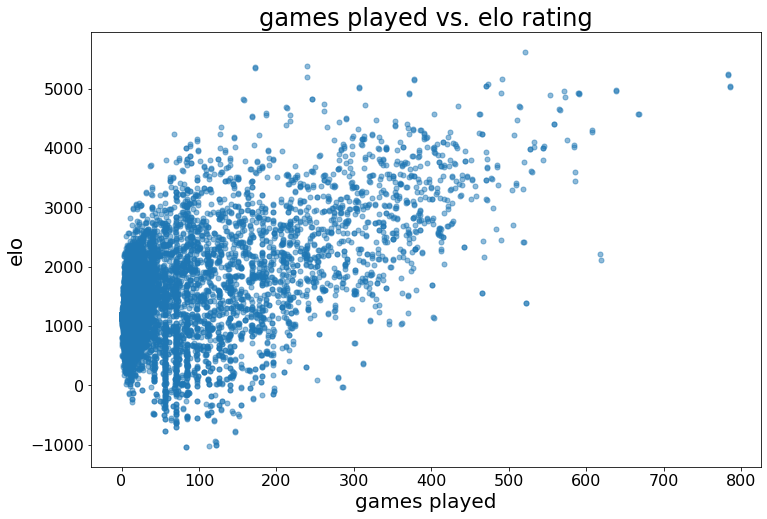

In [ ]:
plt.scatter(samp_size, elo_rt, alpha=0.5, s = 25)
plt.title("games played vs. elo rating")
plt.xlabel("games played")
plt.ylabel("elo")
#plt.axis([0, 800, -1000, 6000])
plt.show()